# Neural Networks in Action for Time Series Forecasting

### Objective: Understand and implement CNNs and LSTMs by forecasting the Nifty500 returns
### Data Source : CEIC

# Installing pre-requisites

#### Installing Anaconda

You can install Anaconda from the following link

https://www.anaconda.com/distribution/


However, before installing Anaconda,do refer to the image attached below and remember to select ‘Add Anaconda to my PATH environment variable’ (ignore any warning against doing the same) while you’re installing Anaconda.

<img src="conda_installation.png" alt="Drawing" style="width: 500px;"/>

The whole installation process should not take more than 5-10mins 

##### Installing key python libraries

Having installed Anancoda with the aforementioned options selected. Run the following two lines in your command prompt.
- You can find the command prompt by typing 'cmd' in your search bar as follows:

<img src="cmd.png" alt="Drawing" style="width: 500px;"/>

Once the command prompt is open,run the following two lines (starting with pip) in it:

- pip install tensorflow==1.15.0

- pip install keras==2.3.1 

# Importing Basic Libraries 

In [4]:
#make sure you have the correct versions installed
import keras
import tensorflow as tf
print(tf.__version__)
print(keras.__version__)

Using TensorFlow backend.


1.15.0
2.3.1


In [5]:
#check version of tensorflow
import random as rn

import numpy as np
import pandas as pd
import os
import glob
import datetime

# 1. Load the data

In [6]:
#changing the directory to where you have downloaded the data
os.chdir('C:\\Users\\Cafral\\Desktop\\CAFRAL\\Intro MLTS\\cfa_data')

df = pd.read_csv('cfa_nn_data.csv')

df.drop(['Unnamed: 0'],inplace=True,axis=1) #removing unnecessary columns

#reformatting and sorting by date
df['date'] = pd.to_datetime(df['date']) #always format the date
df = df.sort_values(['date'])

# 2. Cleaning the Data

### 2.1 Next, it is important to drop weekends as the Indian stock market does not normally trade on weekends.

In [7]:
#Removing weekends
df = df[(df['date'].dt.dayofweek != 5)&(df['date'].dt.dayofweek != 6)]

### 2.2 Now, dealing with missing values: first , all the columns with more that 10% of missing values are dropped.

In [8]:
#dropping if ptage of missing values is greater than 10%
df = df.loc[:, df.isna().sum()/df.shape[0] <= 0.1]
df = df.dropna(axis=0,how='all',subset=df.columns[1:])
df

,date,Bombay Stock Exchange: Index: 100,Bombay Stock Exchange: Index: SENSEX,Bombay Stock Exchange: Index: 200,Bombay Stock Exchange: Index: Dollex-200,Bombay Stock Exchange: Index: 500,Bombay Stock Exchange: Index: Information Technology,Bombay Stock Exchange: Index: Capital Goods,Bombay Stock Exchange: Index: Fast Moving Consumer Goods,Bombay Stock Exchange: Index: Consumer Durables,...,National Stock Exchange: Index: Nifty 500,National Stock Exchange: PE Ratio: Nifty 50,National Stock Exchange: PB Ratio: Nifty 50,National Stock Exchange: Dividend Yield: Nifty 50,National Stock Exchange: Turnover: Value,National Stock Exchange: Turnover: Volume,National Stock Exchange: Turnover: Trade: Advance,National Stock Exchange: Turnover: Trade: Decline,National Stock Exchange: Trade,National Stock Exchange: Market Capitalization: Total
2,2000-01-03,1636.49,5375.11,635.04,243.17,1920.08,4260.20,1196.46,1172.50,1526.33,...,1291.55,25.91,4.63,0.95,17533.5,76.083,1020.0,142.0,267038.0,9121240.0
3,2000-01-04,1690.67,5491.01,652.91,249.89,1972.29,4554.08,1179.47,1138.74,1517.65,...,1335.45,26.67,4.76,0.92,42680.2,106.734,464.0,747.0,445618.0,9369010.0
4,2000-01-05,1643.14,5357.00,636.89,243.65,1922.87,4342.29,1145.40,1116.22,1470.10,...,1303.80,25.97,4.64,0.95,71379.8,146.836,387.0,790.0,651968.0,9186620.0
5,2000-01-06,1644.78,5421.53,636.96,243.68,1923.36,4160.10,1174.28,1168.77,1531.15,...,1306.60,26.32,4.70,0.94,53708.6,124.514,631.0,511.0,529011.0,9221700.0
6,2000-01-07,1606.46,5414.48,620.91,237.59,1871.82,3828.79,1138.47,1207.37,1497.40,...,1276.30,26.25,4.69,0.94,32486.1,101.047,317.0,795.0,372075.0,9022490.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7355,2020-02-20,12194.91,41170.12,5093.30,1183.53,15787.45,16346.38,16654.35,11496.05,27517.60,...,9958.65,27.50,3.40,1.26,439231.0,2553.175,929.0,906.0,13907421.0,157115978.4
7356,2020-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7359,2020-02-24,11941.07,40363.23,4989.47,1156.22,15469.29,16176.41,16374.24,11308.68,26874.39,...,9758.20,26.92,3.33,1.29,391078.9,2218.018,478.0,1382.0,13394376.0,153933963.2
7360,2020-02-25,11903.01,40281.20,4972.74,1151.86,15418.71,16270.52,16262.28,11306.25,26572.20,...,9724.70,26.85,3.32,1.29,368710.7,2024.810,683.0,1153.0,12330735.0,153410437.1


### 2.3 Second, for the remaining columns with at most 10% missing observation, the missing values are fillied using linear interpolation. 

In [82]:
#linear interpolation to deal with missing data
date = df['date']
df = df[df.columns[1:]].astype(float).interpolate(method ='linear',axis = 0,limit=30,
                                                              limit_direction ='forward')

#sort by date
df['date'] = date
df = df.sort_values(['date'])

# 3. Making the Data Stationary

#### 3.1  What is stationarity? 
- Stationarity is a property of time series data stating that the distributional properties (mean and standard deviation) of the data series has not changed across time. 


#### 3.2  Why is it important to have stationarity data? 
- For forecasting it is important that the data be stationary because in the absence of stationarity, one is asking the model to predict data that is nothing like anything it has seen before.

#### 3.4 How do you test for stationarity?
- A common test of stationarity is the Dickey-Fuller Test. 
- If the p-value associated with the Dickey-Fuller Test statistic is greater than 0.05, we state that the data is not stationary.

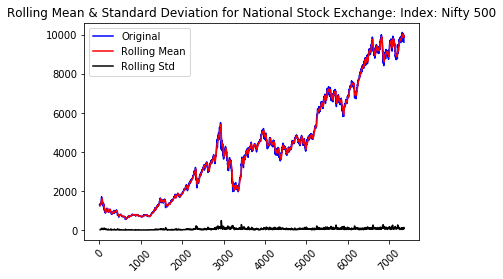

Results of Dickey-Fuller Test:
Test Statistic                    0.078353
p-value                           0.964552
# Lags Used                      13.000000
Number of Observations Used    5244.000000
Critical Value (1%)              -3.431598
Critical Value (5%)              -2.862091
Critical Value (10%)             -2.567063
dtype: float64


In [83]:
# Defining a function to test stationarity
#SOURCE:https://github.com/tklouie/PyData_LA_2018/blob/master/PyData_LA_2018_Tutorial.ipynb

import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
from statsmodels.tsa.stattools import adfuller
import statsmodels.tsa.x13
from statsmodels.tsa.x13 import x13_arima_select_order, _find_x12
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.graphics.tsaplots as tsaplots

def test_stationarity(df, ts):

    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 12, center = False).mean()
    rolstd = df[ts].rolling(window = 12, center = False).std()

    # Plot rolling statistics:
    orig = plt.plot(df[ts], color = 'blue',label = 'Original')
    mean = plt.plot(rolmean, color = 'red',label = 'Rolling Mean')
    std = plt.plot(rolstd, color = 'black', label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()

    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = statsmodels.tsa.stattools.adfuller(df[ts], autolag='AIC') #add kpss
    
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value', '# Lags Used','Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
#Applying the function to our Y variable: National Stock Exchange: Index: Nifty 500
test_stationarity(df, 'National Stock Exchange: Index: Nifty 500')

- From the above results, we see that the p-value is  0.964552, leading to the conclusion that the Nifty500 Index series is not staionary. 
- It can be futher seen more clearly from the graph - the clear upward trend of the rolling mean and rolling standard deviation signals that Nifty500 is not stationary.

### 3.5  So what should one do when the data is not stationary? Make the data as stationary as possible

The easiest was of making the data stationary is to claculate the first difference:
- For level variables (like indices), the first difference in the percentage change vis-a-vis the previous time period
- For percentage variables, its the value of the variable in the current time period subtracted from the value of the variables at the previous date. 

In [84]:
#Defining a function to calculate percentage change
def percentChange(x,numLags):
    '''
    INPUTS:
    x: Column for which we want to calculate percent change
    numLags: The number of days from when the change needs to be calculated. 
            Example : If using daily data - numLags = 1 for daily change
                                            numLags = 30 for monthly change
                                            numLags = 365 for yearly change       
    OUTPUT:
    percentage change in variable
    '''
    y = (x - x.shift(numLags))/x.shift(numLags)
    return y

dataForMl = pd.DataFrame()
dataForMl['date'] = df['date']

#here, I only have level variables so I do not need separate my variables into level vs non-level variables
levelVars = df.columns[:-1]
for levelVar in levelVars:
    dataForMl[f'{levelVar}Ret'] = percentChange(df[levelVar],1)
    
dataForMl = dataForMl[1:] #ignoring the first row as it contains null values

Having calculated the percentage change for all our variables, let's check if our data is stationary now

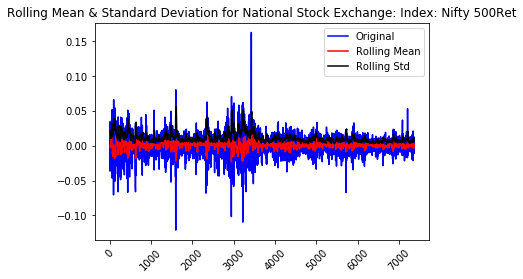

Results of Dickey-Fuller Test:
Test Statistic                -1.741829e+01
p-value                        4.842084e-30
# Lags Used                    1.300000e+01
Number of Observations Used    5.243000e+03
Critical Value (1%)           -3.431598e+00
Critical Value (5%)           -2.862091e+00
Critical Value (10%)          -2.567064e+00
dtype: float64


In [85]:
test_stationarity(dataForMl, 'National Stock Exchange: Index: Nifty 500Ret')

- From the above graphs, we see that the percentage change in Nifty 500 Index (i.e. National Stock Exchange: Index: Nifty 500Ret) is stationary as the p-value is less that 0.05. 
- Again, for greater intuition look at the graph - the rolling mean and rolling standard deviation lines are along are almost flat meaning that they don't change in a statistically significant manner over time.
- However, do note that taking the first difference does not necessarily have to make the data stationary.

# 4. Lagging the Data

- Next, because sequential/time series data is auto regressive in nature - i.e. the outcome today depends on the outcome yesterday and the outcome the day before yesterday and so on - we need to create lagged versions of each independent ariable. 

#### So how many lags of the independent variables do we want to include?

- The maximum number of lags of the dependent variable to use can be decided from the Autocorrelation Function (ACF) and/or Partial Autocorrelation Function (PACF) plot or decided huristically based on domain specific cycles (ex:a business cycle,seasons etc). 
> ##### Autocorrelation function (ACF). At lag k, this is the correlation between series values that are k intervals apart.
> ##### Partial autocorrelation function (PACF). At lag k, this is the correlation between series values that are k intervals apart, accounting for the values of the intervals between.

- The maximum number of lags of other independent variables to include is rather arbitrary -  can be decided huristically based on domain specific cycles (ex:a business cycle,seasons etc). 

- The minimum number of lags to include depending on the forcasting horizon. If you want to forecast h steps ahead, you exclude the first h lags.


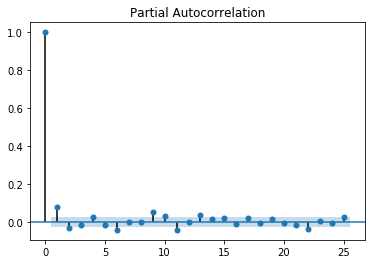

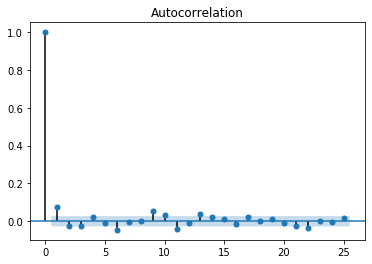

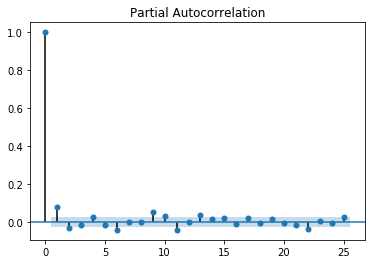

In [86]:
# We can make the acf and pacf plots using the statsmodels library in Python
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.graphics.tsaplots as tsaplots
from statsmodels.graphics.tsaplots import plot_acf

tsaplots.plot_acf(dataForMl['National Stock Exchange: Index: Nifty 500Ret'].astype(float),lags =25)
tsaplots.plot_pacf(dataForMl['National Stock Exchange: Index: Nifty 500Ret'].astype(float),lags =25)

- Both the ACF and PACF plots show high serial correlation at the first lag. 

In [87]:
# Since we're going to forecast the one day ahead Nifty stock returns, the minimum lag considered by me is 1
minLagNum = 1

#lagging the vars :here i'm iginoring the ACF and PACF lag structure and deciding the maximum number of lags heuristically
maxLagNum = 10 #here I have chosen the maxLagNum arbitrarily. A better strategy is to look at the acf plot
dataForMl = dataForMl.sort_values(['date'])
for column in dataForMl.columns:
    for lag in range(minLagNum,maxLagNum+1):
        dataForMl[f'{column}Lag_{lag}'] = dataForMl[f'{column}'].shift(lag)
        

dataForMl.head(5)

,date,Bombay Stock Exchange: Index: 100Ret,Bombay Stock Exchange: Index: SENSEXRet,Bombay Stock Exchange: Index: 200Ret,Bombay Stock Exchange: Index: Dollex-200Ret,Bombay Stock Exchange: Index: 500Ret,Bombay Stock Exchange: Index: Information TechnologyRet,Bombay Stock Exchange: Index: Capital GoodsRet,Bombay Stock Exchange: Index: Fast Moving Consumer GoodsRet,Bombay Stock Exchange: Index: Consumer DurablesRet,...,National Stock Exchange: Market Capitalization: TotalRetLag_1,National Stock Exchange: Market Capitalization: TotalRetLag_2,National Stock Exchange: Market Capitalization: TotalRetLag_3,National Stock Exchange: Market Capitalization: TotalRetLag_4,National Stock Exchange: Market Capitalization: TotalRetLag_5,National Stock Exchange: Market Capitalization: TotalRetLag_6,National Stock Exchange: Market Capitalization: TotalRetLag_7,National Stock Exchange: Market Capitalization: TotalRetLag_8,National Stock Exchange: Market Capitalization: TotalRetLag_9,National Stock Exchange: Market Capitalization: TotalRetLag_10
3,2000-01-04,0.033107,0.021562,0.028140,0.027635,0.027192,0.068983,-0.014200,-0.028793,-0.005687,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000-01-05,-0.028113,-0.024405,-0.024536,-0.024971,-0.025057,-0.046506,-0.028886,-0.019776,-0.031331,...,0.027164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2000-01-06,0.000998,0.012046,0.000110,0.000123,0.000255,-0.041957,0.025214,0.047079,0.041528,...,-0.019467,0.027164,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2000-01-07,-0.023298,-0.001300,-0.025198,-0.024992,-0.026797,-0.079640,-0.030495,0.033026,-0.022042,...,0.003819,-0.019467,0.027164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2000-01-10,0.012219,0.019191,0.015332,0.038722,0.015290,0.014830,0.022319,0.039847,0.033632,...,-0.021602,0.003819,-0.019467,0.027164,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
#sort by date
dataForMl = dataForMl.sort_values(['date'])

#removing columns if nan value in a column
dataForMl = dataForMl.dropna()

#specifying independent variables:including only lagged versions of variables and excluding date variables
final_vars = [col for col in dataForMl.columns if (col.find('Lag')!=-1) & (col.find('date')==-1)]

#specifying the dependent variable
dep_var = 'National Stock Exchange: Index: Nifty 500Ret'

#always make the dependent ariable the last column in the dataset
final_vars.append(dep_var)

#for later use
dataForMl_copy = dataForMl

#keeping only relevant 
dataForMl = dataForMl[final_vars]

# 5. Training, Validation and Testing

- The objective of a machine learning methods is to predict the dependent variable as accurately as possible i.e. to minimize the predicted error (the difference between the actual value and predicted value).

- To measure the predictive accuracy of a model, it is important that the forecast accuracy be measured out-of sample as the training accuracy can be made arbitrarily high through overfitting. 
- However, if we use the entire out-of-sample data for testing, we may overfit to the out-of-sample data (a phenomenon known as ‘data leakage’), resulting poor true generalizability. 
- To protect against ‘data leakage’, we split the out-of-sample data into two parts: validation data and testing data. 

- The validation  set allows the evaluation of the model on unseen data to select the best model architecture, while still holding out a subset of data for final evaluation after finding the best model. 

### 5.1 The training, validation and testing data can be organized in many ways, namely:
- cross validation (bootstrap sampling for cross sectional methods) : not suited for time series
- fixed window (training, validation and testing periods demarcated by dates)
- rolling window (shifting a window of fixed size ahead by one observation successively) / expanding window (increasing the window size by 1 successively). 

Given the time constraint, here I choosed a fixed window approach. The rolling or expanding window approach is highly reccomended if the time is available. 

In [44]:
#breaking the data into train and test along time dim
test_percent = 0.10
no_test_obs =  int(np.round(test_percent*len(dataForMl)))
training = dataForMl[:-no_test_obs]
testing = dataForMl[-no_test_obs:]

#breaking the testing data into validation and out of sample data
validation_percent = 0.70
no_validation_obs = int(np.round(validation_percent*len(testing)))
validation = testing[:-no_validation_obs]
outOfSample = testing[-no_validation_obs:]

# 6. Rescaling Normalized Data

- Normailze the data in the training sample because machine learning methods are not scale invariant
- Then we scale it to being between -1 and 1 as that is the appropriate scaling for data when being input into a Convolutional Neural Network (CNN) and Long Short Term Memory Network(LSTM). 
- Here this scaling for all the methods to make the prediction errors comparable.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

min_max_scaler = MinMaxScaler(feature_range=(-1, 1))
trainMinmax = min_max_scaler.fit_transform(training.values) #fit and transform training data
valMinmax = min_max_scaler.transform(validation.values)
outSampleMinmax = min_max_scaler.transform(outOfSample.values)

#### Note that the rescaling parameters from the training sample are used to rescale the data in the validation and testing samples to ensure that the out-of-sample data does not have a look forward bias or 'data leakage'.

In [46]:
#breaking the data into independent variables (x) and dependent variables (y)

#training independent, dependent
trainMinmax_x,trainMinmax_y = trainMinmax[:,:-1],trainMinmax[:,-1] 

#validation independent, dependent
valMinmax_x,valMinmax_y = valMinmax[:,:-1],valMinmax[:,-1]

#out of sample testing independent, dependent
outSampleMinmax_x,outSampleMinmax_y = outSampleMinmax[:,:-1],outSampleMinmax[:,-1]

# 7.  Metric to be used to guage accuracy of forecasts
- The most commonly used metric for guaging the accuracy of time series forecasts is the Mean Squared Error (MSE)
- The higher the MSE, the worse is the predictive accuracy of the model.
- Thus for each model,it is desired that the MSE be minimized. 

In [47]:
from sklearn.metrics import mean_squared_error

# 8. Time Series Forecasting

In [3]:
os.chdir('C:\\Users\\Cafral\\Desktop\\CAFRAL\\Intro MLTS\\')

### 8.1 So why is Linear Regression (OLS) not best suited for forecasting Time Series Data?

<img src="ols_short_comings.PNG" alt="Drawing" style="width: 800px;"/>

###  8. 2 Potential Solution : Seasonal Autoregressive Integrated Moving Average (SARIMA)

### 8.2.1 What is SARIMA?
- ARIMA models describe how each successive observation is related to the previous observation
- The seasonal ARIMA (SARIMA) is capable of modelling the seasonal components in a univariate time series in addition to the autoregressive, moving average and trend components typically modelled by ARIMA.

In [105]:
#DEFINING SARIMA MODEL
import statsmodels.tsa.stattools
import statsmodels.api as sm

#(p,d,q) are determined using  Autocorrelation Function (ACF) , Partial Autocorrelation Functions (PACF) and tests for stationary.  
#How do we interpret ACF and PACF plots?

#p – Lag value where the PACF chart crosses the upper confidence interval for the first time.
#q – Lag value where the ACF chart crosses the upper confidence interval for the first time.

p= 1 #the trend autoregressive order.
d= 0 #the trend difference order.
q= 1 #the trend moving average order

P= 1 #the number of seasonal autoregressive terms.
D= 0 #the number of seasonal difference terms
Q= 1 #the number of seasonal moving average terms
M=1 #the number of time steps for a seasonal period 

myorder = (p,d,q)
myseasonalorder = (P,D,Q,M)
model = sm.tsa.statespace.SARIMAX(trainMinmax_y,
                                  order=myorder, 
                                  seasonal_order=myseasonalorder,
                                  trend='c')#,exog=trainMinmax_x 

#Training the model
model_fit = model.fit() 

# In case you want to add exgogenous variables
#exogNormal = normalizer.transform(testing.values)
#exogMinmax = min_max_scaler.transform(exogNormal)
#exogMinmax_x,exogMinmax_y = exogMinmax[:,:-1],exogMinmax[:,-1]

#Predicting
totat_preds = len(testing)#len(exogMinmax_y)
sarimaPred = model_fit.predict(start=1, end=totat_preds)#exog=exogMinmax_x

In [138]:
def plot_results(actual_y,predicted_y,method,date):
    mse = mean_squared_error(actual_y,predicted_y)
    
    plt.figure(figsize=(16,4))
    plt.plot(date,actual_y)
    plt.plot(date,predicted_y)
    plt.legend(['Actual','Predicted'])
    plt.title(f'{method} (MSE: {mse})')        
    plt.show()

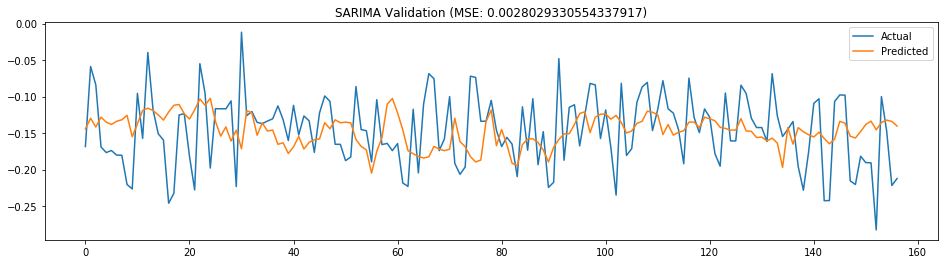

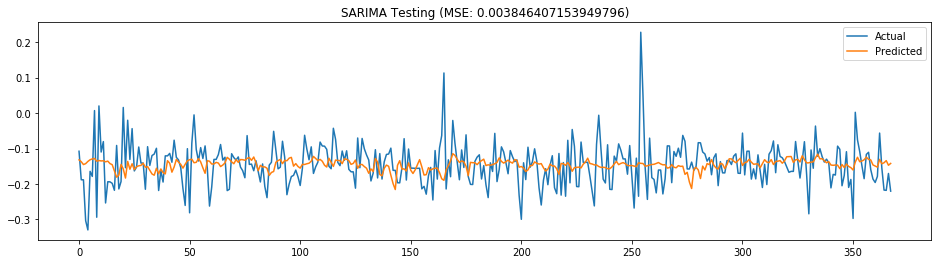

In [139]:
plot_results(valMinmax_y,sarimaPred[:len(valMinmax_y)],'SARIMA Validation',range(len(valMinmax_y)))
plot_results(outSampleMinmax_y,sarimaPred[len(valMinmax_y):],'SARIMA Testing',range(len(outSampleMinmax_y)))

![](sarima_vs_ols.PNG==100x20)

### 8.2.2 SARIMA vs. OLS for Time Series Data
<img src="sarima_vs_ols.PNG" alt="Drawing" style="width: 800px;"/>


### 8.2.3 Additional disadvantages of SARIMA : challenges of ARIMA models
- Potential for error propagation
- Backward looking: “they are generally poor at predicting turning points (unless the turning point represents a return to a long-run equilibrium)”.
- Mean-reverting: As the number of steps forecasted ahead in the future increases , the forecast converges to the mean
> But this is not a problem limited to ARIMA type models

### 8.3 Potential Solution : Deep Neural Networks (DNNs)

#### 8.3.1 Why Only Focus on Deep Neural Networks?
<img src="why_only_nn.PNG" alt="Drawing" style="width: 600px;"/>

#### 8.3.2 What is a Neural Network?

- In general, neural networks are composite functions which are universal function approximators.

- Every neural network is broadly composed of three types of layers: 

  a. the input layer
  
  b. the hidden layer / the computational layer
  
  c. an output layer

- Each of the 3 layers is comprised of multiple nodes and is connected to the subsequent layer through weights

For some intution, let's model a linear regression with 3 independent variable as a neural network:
<img src="lin_reg_as_nn.PNG" alt="Drawing" style="width: 800px;"/>

#### 8.3.3 What is a deep neural network?
- Neural Network with Multiple Hidden Layers

#### 8.3.4 Where does the ‘learning’ in a neural network come from?

<img src="dnn_learn_ffn.PNG" alt="Drawing" style="width: 800px;"/>

#### 8.3.5 But Not All Neural Networks Are Suited for Time Series…
- Look at linear regression as a neural network : 

    1) firstly,it treats the data cross sectionally. What does that mean?
    
    2) no new features are created : does not find non-linearities in the data 
        Solution: Use a deep learning network -> creates non-linearities -> but problem: still treats data cross sectionally
- Thus, a feed forward neural network cannot guage information from the spatial and sequential nature of time series data 
- Thus, it is not recommended that a fully connected feed forward neural network because it is dominated by more complex deep neural networks that can infer information from time series data
- Here we consider two methods:

    A) 1 Dimensional Convolutional Neural Networks (1D-CNNs)
  
    B) Long Short Term Memory (LSTM) Networks
    
#### 8.3.6 What makes CNNs and LSTMs different?
- OLS and SARIMA depend on hand-selected independent variables supplied manually
  - They do not use these independent variables to create new independent variables or 'features'
- However, both CNNs and LSTMs can “learn an internal representation of the time series data and ideally achieve comparable performance to models fit on a version of the dataset with engineered features” 
    How?
    - The input layer preserves the temporal structure of data
    - The hidden layer/s use complex computational nodes: The different computational nodes used in a CNN vis-à-vis a LSTM network result in the two  type of networks processing the data differently.
    
#### 8.3.7 What does it mean to preserve the temporal structure of the data?

In [59]:
from numpy import array

#split a multivariate sequence into samples that preserve the temporal structure of the data
#SOURCE:https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [60]:
n_steps_in =30 #number of observations from the past that we assume to be relevant across time for forecasting
n_steps_out = 1 #number of units ahead that we want to forecast into the future

#training sequence
trainSeq_x, trainSeq_y = split_sequences(trainMinmax, n_steps_in,n_steps_out)

#out of sample sequence
validationSeq_x, validationSeq_y= split_sequences(valMinmax, n_steps_in,n_steps_out)

#out of sample sequence
outSampleSeq_x, outSampleSeq_y= split_sequences(outSampleMinmax, n_steps_in,n_steps_out)

In [61]:
trainMinmax.shape #Output: (rows,columns)

(4722, 601)

In [62]:
trainSeq_x.shape #Output: (number of samples,size of 'window' /timesteps,number of independent variables)

(4693, 30, 600)

### Important

- The intitial weights of a neural network at assigned randomly and greatly affect how the network performs. 
- If you run your neural network - with the exactly same code and hyper-parameters - repeately, you will get different results
 - Solution: Fix the random weights to the same weights every time the neural network is run

### 8.4 Convolutional Neural Network

- Convolutional neural networks (CNNs) can extract information from the temporal structure of the data by:
       a) preserving the spatial/ temporal structure of the data in the input layer
       b) using filters which look for patterns in spatially adjacent data
       - For instance, one filter could finding pseaks, another could find troughs while another could find a linear trend
       - The information extracted by the filters is known as a feature map
       - Each additional feature results in a new feature map extracting a more complex feature
       - For a time series dataset, a filter can only move along 1 dimension - time

- The CNN layer may be followed by a sub-sampling layer which reduces the noise in the learned features (i.e. the feature maps)

- The sub-sampling layer is followed by a regression layer


In [143]:
# Implementing a neural network in Keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, AveragePooling1D,MaxPooling1D
from keras.layers import Conv1D,AveragePooling1D,MaxPooling1D
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, SGD, Nadam
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l1,l2,l1_l2

In [99]:
############################# For Replicability : Always run this as one cell ##########################################
#SOURCE :
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.random.set_random_seed(1234)
#from keras import backend as K
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
###########################################################################################################################

#While training the neural network, it is important that we use the MSE error of the validation set to decide when to 
#stop training our network. If we use the MSE of the training set, we will not get good predictions in the test set due 
#to over fitting. However, unlike the error in the training set, the error in the validation set does not reduce with 
#every passing epoch. Sometimes, it increases for a while before it starts declining. The patience argument in Earlystop allows us 
#to decide how many times we want the validation error to keep increasing before we stop training the neural network.

EarlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto',restore_best_weights=True)

epochs = 100000 #number of times the feed forward mechanism and back propagation are repeated 

bs = 100 #batch size for SGD :show what happens when batch size very small
lr =0 #learning rate: the degree to which the weights are updated by each batch of SGD

sgd = SGD(lr=lr) #type of optimizer - Alternative: ADAM, NADAM

X, y = split_sequences(trainMinmax, n_steps_in,n_steps_out)
n_features = X.shape[2]

np.random.seed(0)

model = Sequential() #initializing keras Sequential model

#convolutional layer starts
model.add(Conv1D(filters=5,#number of filters
                 kernel_size=2,#size of the filte racross time
                 strides=2, #number of rows that the filter moves ahead by
                 activation='linear',#transformation
                 input_shape=(n_steps_in, n_features))) #shape of 1 sample : preserves temporal structure
                #kernel_regularizer=l2(0.009),, bias_regularizer=l2(0.01)
#convolutional layer ends

model.add(MaxPooling1D(pool_size=1)) #sub-sampling layer - Alternative: AveragePooling1D

#model.add(BatchNormalization())
model.add(Dropout(0.1)) #reduces overfitting by dropping some weights randomly

#regression layer begins
model.add(Flatten())
model.add(Dense(1,#number of outputs
                activation='tanh',#transformation:other options include - ReLU,Linear,Sigmoid
                kernel_regularizer=l2(0.01))) 

model.compile(loss='mean_squared_error', optimizer='sgd') #specifies which optimizer and loss funtion to useto use 

#training the model
model.fit(trainSeq_x, trainSeq_y,
          batch_size=bs,
          epochs=epochs, 
          callbacks= [EarlyStop],
          verbose=2, 
          shuffle=False,#always set to false for time series data
          validation_data =(validationSeq_x, validationSeq_y))
                         
    
model.summary()

Train on 4693 samples, validate on 128 samples
Epoch 1/100000
 - 1s - loss: 0.1225 - val_loss: 0.0313
Epoch 2/100000
 - 1s - loss: 0.0532 - val_loss: 0.0297
Epoch 3/100000
 - 1s - loss: 0.0473 - val_loss: 0.0278
Epoch 4/100000
 - 1s - loss: 0.0439 - val_loss: 0.0242
Epoch 5/100000
 - 1s - loss: 0.0407 - val_loss: 0.0250
Epoch 6/100000
 - 1s - loss: 0.0388 - val_loss: 0.0222
Epoch 7/100000
 - 1s - loss: 0.0361 - val_loss: 0.0212
Epoch 8/100000
 - 2s - loss: 0.0349 - val_loss: 0.0208
Epoch 9/100000
 - 1s - loss: 0.0335 - val_loss: 0.0200
Epoch 10/100000
 - 1s - loss: 0.0328 - val_loss: 0.0192
Epoch 11/100000
 - 1s - loss: 0.0314 - val_loss: 0.0187
Epoch 12/100000
 - 1s - loss: 0.0306 - val_loss: 0.0183
Epoch 13/100000
 - 1s - loss: 0.0298 - val_loss: 0.0175
Epoch 14/100000
 - 1s - loss: 0.0290 - val_loss: 0.0171
Epoch 15/100000
 - 1s - loss: 0.0281 - val_loss: 0.0166
Epoch 16/100000
 - 1s - loss: 0.0277 - val_loss: 0.0162
Epoch 17/100000
 - 1s - loss: 0.0271 - val_loss: 0.0157
Epoch 18/1

Epoch 146/100000
 - 1s - loss: 0.0102 - val_loss: 0.0029
Epoch 147/100000
 - 1s - loss: 0.0101 - val_loss: 0.0029
Epoch 148/100000
 - 1s - loss: 0.0102 - val_loss: 0.0028
Epoch 149/100000
 - 1s - loss: 0.0101 - val_loss: 0.0028
Epoch 150/100000
 - 1s - loss: 0.0102 - val_loss: 0.0028
Epoch 151/100000
 - 1s - loss: 0.0101 - val_loss: 0.0028
Epoch 152/100000
 - 1s - loss: 0.0101 - val_loss: 0.0028
Epoch 153/100000
 - 1s - loss: 0.0101 - val_loss: 0.0028
Epoch 154/100000
 - 1s - loss: 0.0101 - val_loss: 0.0028
Epoch 155/100000
 - 1s - loss: 0.0101 - val_loss: 0.0028
Epoch 156/100000
 - 1s - loss: 0.0101 - val_loss: 0.0028
Epoch 157/100000
 - 1s - loss: 0.0100 - val_loss: 0.0027
Epoch 158/100000
 - 1s - loss: 0.0101 - val_loss: 0.0027
Epoch 159/100000
 - 1s - loss: 0.0100 - val_loss: 0.0027
Epoch 160/100000
 - 1s - loss: 0.0101 - val_loss: 0.0027
Epoch 161/100000
 - 1s - loss: 0.0100 - val_loss: 0.0027
Epoch 162/100000
 - 1s - loss: 0.0100 - val_loss: 0.0027
Epoch 163/100000
 - 1s - loss: 

Epoch 290/100000
 - 1s - loss: 0.0097 - val_loss: 0.0024
Epoch 291/100000
 - 1s - loss: 0.0097 - val_loss: 0.0024
Epoch 292/100000
 - 1s - loss: 0.0097 - val_loss: 0.0024
Epoch 293/100000
 - 1s - loss: 0.0097 - val_loss: 0.0024
Epoch 294/100000
 - 1s - loss: 0.0097 - val_loss: 0.0024
Epoch 295/100000
 - 1s - loss: 0.0096 - val_loss: 0.0024
Epoch 296/100000
 - 1s - loss: 0.0097 - val_loss: 0.0024
Epoch 297/100000
 - 1s - loss: 0.0097 - val_loss: 0.0023
Epoch 298/100000
 - 1s - loss: 0.0097 - val_loss: 0.0024
Epoch 299/100000
 - 1s - loss: 0.0097 - val_loss: 0.0024
Epoch 300/100000
 - 1s - loss: 0.0097 - val_loss: 0.0023
Epoch 301/100000
 - 1s - loss: 0.0096 - val_loss: 0.0023
Epoch 302/100000
 - 1s - loss: 0.0097 - val_loss: 0.0023
Epoch 303/100000
 - 1s - loss: 0.0097 - val_loss: 0.0023
Epoch 304/100000
 - 1s - loss: 0.0097 - val_loss: 0.0023
Epoch 305/100000
 - 1s - loss: 0.0097 - val_loss: 0.0023
Epoch 306/100000
 - 1s - loss: 0.0096 - val_loss: 0.0023
Epoch 307/100000
 - 1s - loss: 

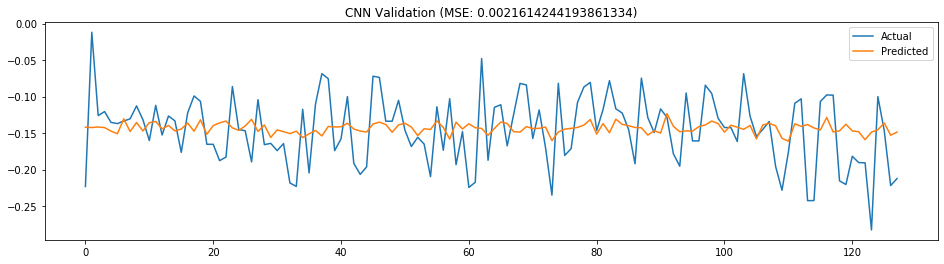

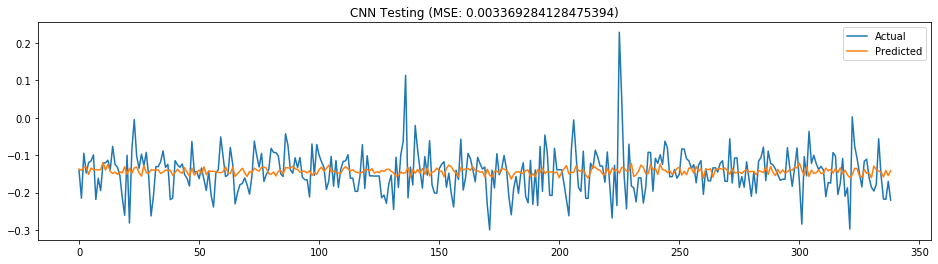

In [104]:
# validation metrics 
cnnValPred = model.predict(validationSeq_x)

#testing prediction
cnnOutSamplePred = model.predict(outSampleSeq_x)
    
plot_results(validationSeq_y ,cnnValPred  ,'CNN Validation',range(len(validationSeq_y)))
plot_results(outSampleSeq_y ,cnnOutSamplePred  ,'CNN Testing',range(len(outSampleSeq_y)))

### 8.5 Long Short Term Memory Network (LSTM)
- A key shortcoming of CNNs for time series data is that they do not draw information from the sequential nature of independent data.
- So, how does one build a neural network that can remember and extract information from a sequence? Long Short Term Memory (LSTM) Network.
    - LSTM networks draw information from the sequential nature of the data because they have memory i.e. it remembers what it has seen
    - LSTMs belong to a larger class of neural networks known as Recurrent Neural Networks, all of which have memory.
    - Of many RNNs , LSTM are chosen here over a vanilla RNN as the former can learn from long sequences while the latter may not.

#### 8.5.1 How does an LSTM network build short and long term memory? 
LSTMs build short and long term memories by revealing data to the hidden nodes in a sequential fashion.

#### 8.5.2 How does sequential revealing allow an LSTM Node to Build Memory?

Each LSTM node is comprised of LSTM cells. 

The long term and short term memory is updated in each LSTM cell upon being exposed to each subsequent element of the sequence , conditional on the output of each ‘gate’.

#### 8.5.3 What is a gate?

- Each “gate” is a neural network with a sigmoid/logistic activation function which determines how the memory updated by accepting as inputs:
    a) the current elements X of the sequence

    b) the outputs of the previous LSTM cell i.e. the long term memory and hidden memory from the previous member of the sequece

- Each gate outputs a number between 0 (meaning no information is transferred ) and 1 (meaning all information is transferred).

- In each LSTM cell, the following gates are used in the following order to build and update long term memory and short term memory:
    - The Forget Gate / Remember Vector
    - Candidate Gate
    - Input Gate / Save Vector
    - Output gate / Focus Vector

- The updated working memory at the end of the sequence is the output of an LSTM node. 
- This working memory or hidden memory is the new internal representation of the data that is learnt by an LSTM network i.e. the working memory is the new feature used as an input in the regression layer.

In [150]:
#best
from keras.layers import LSTM

################################### Set for replicability ##################################################################
np.random.seed(42)
rn.seed(12345)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)
tf.random.set_random_seed(1234)
#from keras import backend as K
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
###########################################################################################################################


EarlyStop = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='auto',restore_best_weights=True)
epochs = 100000
lr =0

sgd = SGD(lr=lr) #; adam = Adam(lr=lr) ;nadam = Nadam(lr=lr)
bs = 100

n_steps_in =30
n_steps_out = 1

#training sequence
trainSeq_x, trainSeq_y = split_sequences(trainMinmax, n_steps_in,n_steps_out)

#out of sample sequence
validationSeq_x, validationSeq_y= split_sequences(valMinmax, n_steps_in,n_steps_out)

#out of sample sequence
outSampleSeq_x, outSampleSeq_y= split_sequences(outSampleMinmax, n_steps_in,n_steps_out)

X_useless, y_useless = split_sequences(trainMinmax, n_steps_in,n_steps_out)
n_features = X_useless.shape[2]

np.random.seed(0); print(np.random.rand(4))

model = Sequential()
model.add(LSTM(300, #number of LSTM nodes
               input_shape=(n_steps_in, n_features),
               activation = 'tanh')) #ransformation:best to not use any other type of transformation
model.add(Dropout(0.1))
model.add(Dense(1,activation = 'linear'))
model.compile(loss='mean_squared_error', optimizer='sgd')

#model
model.fit(trainSeq_x, trainSeq_y,batch_size=bs,epochs=epochs, callbacks= [EarlyStop] ,verbose=2, shuffle=False,
                         validation_data =(validationSeq_x, validationSeq_y))

[0.5488135  0.71518937 0.60276338 0.54488318]
Train on 4693 samples, validate on 128 samples
Epoch 1/100000
 - 20s - loss: 0.3244 - val_loss: 0.0025
Epoch 2/100000
 - 20s - loss: 0.0280 - val_loss: 0.0027
Epoch 3/100000
 - 22s - loss: 0.0254 - val_loss: 0.0027
Epoch 4/100000
 - 23s - loss: 0.0240 - val_loss: 0.0028
Epoch 5/100000
 - 23s - loss: 0.0235 - val_loss: 0.0027
Epoch 6/100000
 - 22s - loss: 0.0225 - val_loss: 0.0025
Epoch 7/100000
 - 22s - loss: 0.0223 - val_loss: 0.0026
Epoch 8/100000
 - 23s - loss: 0.0214 - val_loss: 0.0030
Epoch 9/100000
 - 22s - loss: 0.0203 - val_loss: 0.0026
Epoch 10/100000
 - 23s - loss: 0.0199 - val_loss: 0.0027
Epoch 11/100000
 - 21s - loss: 0.0192 - val_loss: 0.0024
Epoch 12/100000
 - 21s - loss: 0.0180 - val_loss: 0.0028
Epoch 13/100000
 - 21s - loss: 0.0182 - val_loss: 0.0024
Epoch 14/100000
 - 21s - loss: 0.0169 - val_loss: 0.0026
Epoch 15/100000
 - 21s - loss: 0.0169 - val_loss: 0.0024
Epoch 16/100000
 - 21s - loss: 0.0167 - val_loss: 0.0029
Epoc

Epoch 143/100000
 - 20s - loss: 0.0100 - val_loss: 0.0022
Epoch 144/100000
 - 20s - loss: 0.0100 - val_loss: 0.0022
Epoch 145/100000
 - 21s - loss: 0.0099 - val_loss: 0.0022
Epoch 146/100000
 - 21s - loss: 0.0100 - val_loss: 0.0022
Epoch 147/100000
 - 20s - loss: 0.0100 - val_loss: 0.0022
Epoch 148/100000
 - 20s - loss: 0.0100 - val_loss: 0.0022
Epoch 149/100000
 - 21s - loss: 0.0100 - val_loss: 0.0022
Epoch 150/100000
 - 21s - loss: 0.0100 - val_loss: 0.0022
Epoch 151/100000
 - 21s - loss: 0.0098 - val_loss: 0.0022
Epoch 152/100000
 - 20s - loss: 0.0099 - val_loss: 0.0022
Epoch 153/100000
 - 20s - loss: 0.0099 - val_loss: 0.0022
Epoch 154/100000
 - 20s - loss: 0.0100 - val_loss: 0.0022
Epoch 155/100000
 - 20s - loss: 0.0100 - val_loss: 0.0022
Epoch 156/100000
 - 21s - loss: 0.0100 - val_loss: 0.0022


In [151]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 300)               1081200   
_________________________________________________________________
dropout_5 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 301       
Total params: 1,081,501
Trainable params: 1,081,501
Non-trainable params: 0
_________________________________________________________________


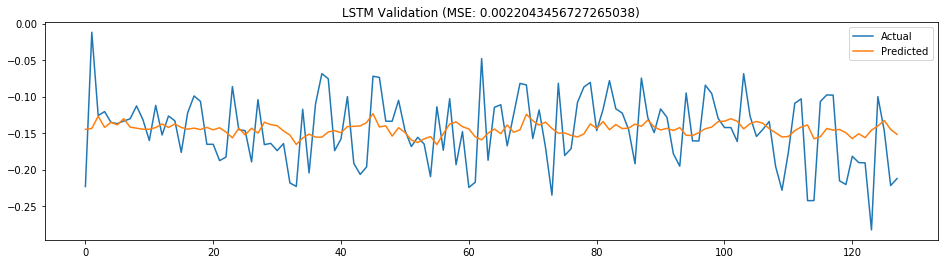

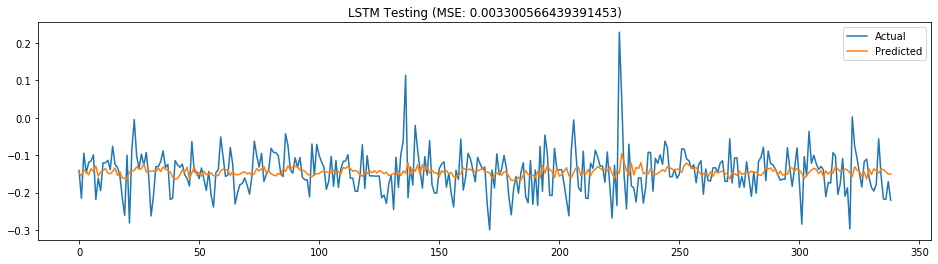

In [152]:
# validation metrics 
lstmValPred = model.predict(validationSeq_x)
#out of sample metrics
lstmOutSamplePred = model.predict(outSampleSeq_x)

plot_results(validationSeq_y ,lstmValPred  ,'LSTM Validation',range(len(validationSeq_y )))
plot_results(outSampleSeq_y ,lstmOutSamplePred  ,'LSTM Testing',range(len(outSampleSeq_y)))

# 9. Saving a Neural Network Model to use it later

In [64]:
# Create directory for storing output
dirName = f'C:\\Users\\Cafral\\Desktop\\CAFRAL\\Intro MLTS\\output' #change name to suitable folder here

try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " Created ") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

####################################### change here onwards #######################################################

#change directory
os.chdir(dirName)

#specify model name
model_name='lstm'
filename = f'{model_name}_model.h5'
model.save(filename)

Directory  C:\Users\Cafral\Desktop\CAFRAL\Intro MLTS\output  Created 


# 10. Calling a Saved Model

In [68]:
import keras

#change directory
model_name='lstm' #change name of your model here
filename = f'{model_name}_model.h5' 
saved_model = keras.models.load_model(filename)


yhat = saved_model.predict(outSampleSeq_x) 
mse = mean_squared_error(outSampleSeq_y,cnnOutSamplePred)
print(mse)

0.003369284128475394


# 11 Invert the Scaling

In [117]:
from numpy import concatenate
def invert_scaling(x_minmax,y_predicted,n_steps_in):
    reshaped_pred = y_predicted.reshape((y_predicted.shape[0],1))
    matrix = concatenate((x_minmax[n_steps_in-1:],reshaped_pred), axis=1)
    matrix_min_max_invert = min_max_scaler.inverse_transform(matrix)
    inv_pred = matrix_min_max_invert[:,-1]
    return inv_pred

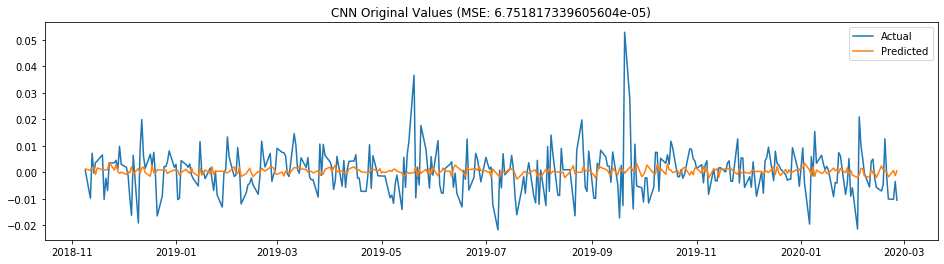

In [141]:
inv_yhat = invert_scaling(outSampleMinmax_x,cnnOutSamplePred,n_steps_in)
plot_results(dataForMl_copy['National Stock Exchange: Index: Nifty 500Ret'][-(no_validation_obs-n_steps_in+1):].values,
             inv_yhat,
             'CNN Original Values',
             dataForMl_copy['date'][-(no_validation_obs-n_steps_in+1):])

# Summary
<img src="summary_full.PNG" alt="Drawing" style="width: 800px;"/>

<img src="hyperpara.PNG" alt="Drawing" style="width: 800px;"/>

# Important Caveats
- Machine learning methods, especially DNNs work best with large amounts of data

# References

Tibshirani and Friedman (2017)

Hastie, James , Tibshirani and Witten (n.d.)

Goodfellow , Bengio and Courville (2016)

https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/
    
https://github.com/tklouie/PyData_LA_2018/blob/master/PyData_LA_2018_Tutorial.ipynb
    
https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

https://stackoverflow.com/questions/38080035/how-to-calculate-the-number-of-parameters-of-an-lstm-network

https://stackoverflow.com/questions/50947079/keras-understanding-the-number-of-trainable-lstm-parameters

https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model/27067#comment39272_27067

https://www.coursera.org/lecture/ai/number-of-parameters-A3N10

https://blog.acolyer.org/2019/02/25/understanding-hidden-memories-of-recurrent-neural-networks/

https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/

http://blog.echen.me/2017/05/30/exploring-lstms/

https://www.youtube.com/watch?v=lUhtcP2SUsg